<a href="https://colab.research.google.com/github/sirius59/ART_AI/blob/sirius59-patch/ART_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binôme T: De Carvalho Mickael et Laisney Clément

algorithme qui prédit le style de l'oeuvre d'art (impressionnisme, pop art, cubisme etc...) et peut être je dit bien PEUT ETRE 
arriver à un algorithme qui créer une oeuvre en fonction du style demandé.

jeu de données:
https://www.kaggle.com/ikarus777/best-artworks-of-all-time

points de départ: 

- réseau de convolution
- réduction de dimension pour classer 

retrouvez notre travail sur https://github.com/sirius59/ART_AI

### Import libraries

In [1]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import to_categorical

### Download the dataset from internet and extract it on the system

**We resized all images to 224x224 with a preview script available in the github page:** https://github.com/sirius59/ART_AI/blob/main/traitement%20des%20images.py

NB: replace the link by a new one using this URL in case of an issue like "file is not a zipfile" https://www.mediafire.com/file/v5jpwfjeldhmc8z/dataset_resized.zip/file

In [3]:
zipurl = 'https://download1638.mediafire.com/u8666loefwdg/v5jpwfjeldhmc8z/dataset_resized.zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall()

# Core of the script

## Extracting metadata from artist.csv and labelize genres

In [2]:
artists=pd.read_csv('/content/dataset_resized/artists.csv')

##name of artists
artists['name'][19]='Albrecht_Durer' #fix ASCII problems
tmp=artists['name']
name=[tmp[i].replace(' ','_') for i in range(len(tmp))]#replace space by underscore, more convinent to import images

##genre of artists
tmp=artists['genre']
genre=[tmp[i].replace(',','/') for i in range(len(tmp))]#replace coma by slash, avoid mistakes in list

##number of paintings by artists
nb_paints=artists['paintings']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Labelize a genre with a number

In [36]:
k=0
genre_label={}
ids=[]
for i in range(len(genre)):
  if '/' in genre[i]:
    continue
  elif genre[i] in genre_label:
    continue
  else:
    genre_label[genre[i]]=k
    k+=1
    ids.append(artists['id'][i])

In [18]:
nb_classes=len(genre_label)

Function to find the key associated with the label

In [19]:
def find_key(v): 
    for k, val in genre_label.items(): 
        if v == val: 
            return k 
    return "Key does not exist"

## Append artworks of differents styles in a list
We first choose 2 differents styles well represented in the dataset en choose 4 artists of each genre in order to have about 50/50 in term of artworks. Finally we add the rest of the dataset

In [20]:
input_shape=plt.imread(f'/content/dataset_resized/resized/{name[0]}_{1}.jpg').shape
artworks=[]
artworks_genre=[]
for i in ids:
  for j in range(nb_paints[i]):
    artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'))
    artworks_genre.append(genre[i])
artworks=np.array(artworks) #images
artworks_genre=np.array(artworks_genre) #string of the genre
artworks_label=np.array([genre_label[artworks_genre[i]] for i in range(len(artworks_genre))]) #integer corresponding to the genre

We choose to represent 2 differents artworks of each genre in order to visualize datas

Text(0.5, 1.0, 'Pop Art')

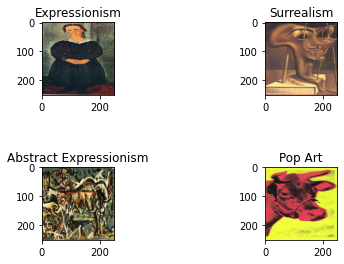

In [21]:
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(artworks[0])
plt.title(f'{artworks_genre[0]}')
plt.subplot(222)
plt.imshow(artworks[300])
plt.title(f'{artworks_genre[300]}')
plt.subplot(223)
plt.imshow(artworks[-1])
plt.title(f'{artworks_genre[-1]}')
plt.subplot(224)
plt.imshow(artworks[-200])
plt.title(f'{artworks_genre[-200]}')

## Shuffle and split of the dataset

In [22]:
prepared_label=to_categorical(artworks_label,num_classes=nb_classes)

In [23]:
x_train,x_test,y_train,y_test=train_test_split(artworks,prepared_label, test_size=0.33, random_state=42, shuffle=True)

## CNN

In [24]:
model=Sequential()

model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(128, kernel_size=4, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))

model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 246, 246, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 128)     131200    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 118, 118, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 445568)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               4

In [35]:
history=model.fit(x_train,y_train, batch_size=64, epochs=20, validation_split=0.33)

Epoch 1/20
27/27 [==============================] - 10s 377ms/step - loss: 1.1815 - accuracy: 0.7163 - val_loss: 5.9275 - val_accuracy: 0.2366
Epoch 2/20
27/27 [==============================] - 10s 374ms/step - loss: 1.0206 - accuracy: 0.7440 - val_loss: 5.7236 - val_accuracy: 0.2533
Epoch 3/20
27/27 [==============================] - 10s 375ms/step - loss: 1.0451 - accuracy: 0.7475 - val_loss: 7.7147 - val_accuracy: 0.2186
Epoch 4/20
27/27 [==============================] - 10s 376ms/step - loss: 0.7902 - accuracy: 0.7981 - val_loss: 9.1438 - val_accuracy: 0.2103
Epoch 5/20
27/27 [==============================] - 10s 378ms/step - loss: 0.6872 - accuracy: 0.8258 - val_loss: 9.5217 - val_accuracy: 0.2282
Epoch 6/20
27/27 [==============================] - 10s 380ms/step - loss: 0.6205 - accuracy: 0.8446 - val_loss: 10.4042 - val_accuracy: 0.2079
Epoch 7/20
27/27 [==============================] - 10s 382ms/step - loss: 0.6610 - accuracy: 0.8499 - val_loss: 10.3069 - val_accuracy: 0.19

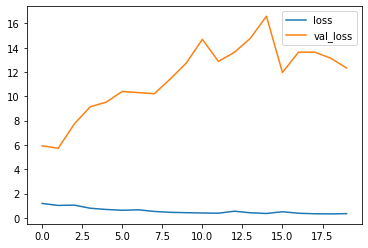

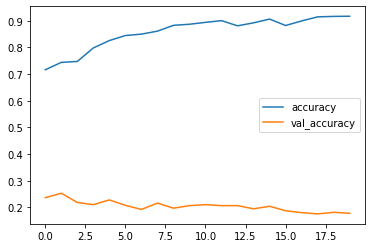

In [37]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [38]:
predict=model.predict(x_test)

In [39]:
label_prediction=np.argmax(predict, axis=1)
label_solution=np.argmax(y_test, axis=1)

Text(0.5, 1.0, 'prediction:Primitivism\n solution:Cubism')

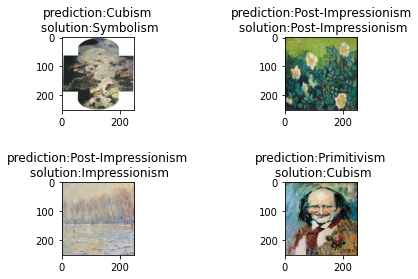

In [40]:
r1,r2,r3,r4=np.random.randint(len(y_test),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(x_test[r1])
plt.title(f'prediction:{find_key(label_prediction[r1])}\n solution:{find_key(label_solution[r1])}')
plt.subplot(222)
plt.imshow(x_test[r2])
plt.title(f'prediction:{find_key(label_prediction[r2])}\n solution:{find_key(label_solution[r2])}')
plt.subplot(223)
plt.imshow(x_test[r3])
plt.title(f'prediction:{find_key(label_prediction[r3])}\n solution:{find_key(label_solution[r3])}')
plt.subplot(224)
plt.imshow(x_test[r4])
plt.title(f'prediction:{find_key(label_prediction[r4])}\n solution:{find_key(label_solution[r4])}')

In [41]:
correct=len(np.where(label_prediction==label_solution)[0])
bad=len(np.where(label_prediction!=label_solution)[0])

In [42]:
efficacity=correct/bad
print(efficacity)

0.2266928361138371
